In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Resize jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"]="3"
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

## prepare data

In [2]:
'''
def make_test_train_split(df_labels, random_state=12):
    idx_train, idx_test = train_test_split(df_labels.ResultFinalCheck, test_size=0.1, random_state=random_state)

    df_train = df_labels.loc[idx_train.index].reset_index(drop=True)
    df_test = df_labels.loc[idx_test.index].reset_index(drop=True)
    
    return df_train, df_test
'''

def plot_curve(df_curve, ax=None):
        
    if not ax:
        _, ax = plt.subplots()
    
    for feature in ['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT']:
        df_curve[feature].plot(ax=ax, label=feature)
    
    ax.legend(loc='lower right')
    ax.set_title(df_curve.name)

def parse_curve(filepath):
    """
    Parses the curve into a pandas dataframe
    
    WegSpd1 	mm 	Distance traveld by press
    KraftSpd1 	N 	Force spend by press
    K7_1_TL 	% 	Sharpness value top left
    K7_2_TR 	% 	sharpness value top right
    K7_3_BL 	% 	sharpness value bottom left
    K7_4_BR 	% 	sharpness value bottom right
    K7_5_MC 	% 	sharpness value middle center
    """
    df = pd.read_csv(
        filepath, 
        skiprows=33, 
        delimiter=';', 
        dtype=np.float,
        names=['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT'],
        usecols=range(9)
    )
    df.name = os.path.basename(filepath)
    return df

In [55]:
class CurveSequence(Sequence):
    """
    Helper class to sample and iterating over the dataset
    
    Args:
        df (pandas.DataFrame): Dataframe holding curve paths and labels
        batch_size (int): The batch size 
        n_timesteps (int): Number of steps to be used from the curves
        curve_path (str): Path to directory where curve folders are located
    """

    def __init__(self, df, batch_size=20, n_timesteps=1950, curve_path='/fs/scratch/ccserver_cc_cr_challenge/mpc2-inspection/'):
        self.df = df.copy()
        self.curve_path = curve_path
        self.batch_size = batch_size
        self.n_timesteps = n_timesteps
        
        #self.df["ResultFinalCheck"] = self.df['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
        
    def make_batch(self, df_sub):
        dfs = [
            parse_curve(
                os.path.join(self.curve_path, filepath)
            ) for filepath in df_sub['FilePath'].values
        ]
        # Think about how to create batches of equal length without truncating the data.
        # Think about necessary data preparations
        # batch_size * 1950 * 9
        X = np.array([
            df[0:self.n_timesteps][['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT']].values for df in dfs
        ]) 
        '''
        X = np.empty(shape=(self.batch_size, self.n_timesteps, 9))
        count = 0
        for df in dfs:
            X[count,:,:] = df[0:self.n_timesteps][['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT']].values
            count = count+1
        '''
        
        X_mean = np.array([0.163551, 13.586131, 30.917057, 30.875045, 30.826165, 30.879995, 28.995421, 12.470428, -472945.497673])
        X_std = np.array([6.119196e-02, 1.619622e+01, 1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01, 1.634376e+01, 2.957244e+06])
        X_train = (X - X_mean) / X_std
        
        return X_train

    def __len__(self):
        return math.ceil(self.df.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        df_sub = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.make_batch(df_sub)

In [4]:
df_train = pd.read_csv('pure_train_5_pec_70_pec.csv')
#df_train, df_test = make_test_train_split(df)
df_train.shape

(51973, 2)

In [11]:
# nok: 7580, ok: 1171406  --> ab ratio: 0.0064 ~ 0.0066
#not_ok = df_train[df_train.ResultFinalCheck == 0]
#ok = df_train[df_train.ResultFinalCheck == 1]
#print(not_ok.shape, ok.shape)

#dfs = [ parse_curve(os.path.join(curve_path, filepath)) for filepath in df['FilePath'].values ] # too large to load

## try-run vae model

In [6]:
#Create a sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
#Build the encoder
latent_dim = 2
intermediate_dim = 128
final_dim = 64

encoder_inputs = keras.Input(shape=(2000, 9))
x = layers.Flatten()(encoder_inputs)
h = layers.Dense(intermediate_dim, activation='relu')(x)
h = layers.Dense(final_dim, activation = 'relu')(h)
z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000, 9)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 18000)        0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          2304128     flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
____________________________________________________________________________________________

In [8]:
#Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
decoder_f = layers.Dense(final_dim, activation='relu')(latent_inputs)
decoder_h = layers.Dense(intermediate_dim, activation='relu')(decoder_f)
decoder_outputs = layers.Dense(2000*9, activation='sigmoid')(decoder_h)
decoder_outputs = layers.Reshape((2000, 9))(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 18000)             2322000   
_________________________________________________________________
reshape (Reshape)            (None, 2000, 9)           0         
Total params: 2,330,512
Trainable params: 2,330,512
Non-trainable params: 0
_________________________________________________________________


In [22]:
#Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, inputs):
        # self._set_inputs(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) # z is sampled from z_mean and z_log_var
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 2000*9
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
#Train the VAE
generator_train = CurveSequence(df_train, batch_size=256)
generator_eval = CurveSequence(df_test, batch_size=256)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
#total train number: 1171406, batch_size=256 --> steps_per_epoch ≈ 4500
vae.fit_generator(generator_train, steps_per_epoch=4500, epochs=30, workers=4, use_multiprocessing=True)

## Valid VAE Model

In [5]:
# model setting
latent_dim = 4
intermediate_dim = 128
final_dim = 64
epsilon_std = 1.0

# define VAE model
encoder_inputs = keras.Input(shape=(1950, 9))
x = layers.Flatten()(encoder_inputs)
h = layers.Dense(intermediate_dim, activation='relu')(x)
h = layers.Dense(final_dim, activation = 'relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = layers.Dense(final_dim, activation='relu')
decoder_h = layers.Dense(intermediate_dim, activation='relu')
decoder_mean = layers.Dense(1950*9, activation='sigmoid')

f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
decoder_outputs = layers.Reshape((1950, 9))(x_decoded_mean)

# instantiate VAE model
vae = keras.Model(encoder_inputs, decoder_outputs)

# Compute VAE loss

xent_loss = tf.reduce_mean(tf.keras.backend.square(encoder_inputs - decoder_outputs)) * 1950 * 9
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_mean(kl_loss)
#kl_loss = - 0.5 * tf.keras.backend.sum(1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var), axis=-1)
vae_loss = xent_loss + kl_loss
'''
KL_divergence = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_log_var) - tf.math.log(1e-8 + tf.square(z_log_var)) - 1, 1)
mse_loss = tf.reduce_sum(tf.square(x - x_decoded_mean), 1)          
vae_loss = tf.reduce_mean(mse_loss + KL_divergence)
'''

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1950, 9)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 17550)        0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          2246528     flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
______________________________________________________________________________________________

In [6]:
#Train the VAE
generator_train = CurveSequence(df_train, batch_size=256)

vae.fit_generator(generator_train, steps_per_epoch=200, epochs=20, workers=4, use_multiprocessing=True)
#vae.fit(generator_train, steps_per_epoch=10, epochs=2, workers=4, use_multiprocessing=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
200/200 [==============================] - 220s 1s/step - loss: 50971978660869975041900544.0000
Epoch 2/20
200/200 [==============================] - 140s 702ms/step - loss: 13443.0488
Epoch 3/20
200/200 [==============================] - 182s 912ms/step - loss: 13323.8359
Epoch 4/20
200/200 [==============================] - 171s 853ms/step - loss: 13261.8174
Epoch 5/20
200/200 [==============================] - 118s 589ms/step - loss: 13181.1201
Epoch 6/20
200/200 [==============================] - 122s 610ms/step - loss: 25764.2441
Epoch 7/20
200/200 [==============================] - 143s 713ms/step - loss: 13127.2158
Epoch 8/20
200/200 [==============================] - 139s 693ms/step - loss: 13115.7598
Epoch 9/20
200/200 [==============================] - 102s 512ms/step - loss: 13101.4746
Epoch 10/20
200/200 [==============================] - 99s 495ms/step - loss: 13094.3213
Epoch 11/20
200/

In [7]:
vae.save_weights('./model/first_blood')

## load model

In [17]:
vae = keras.Model(encoder_inputs, decoder_outputs)
vae.load_weights('./model/first_blood')

## find threshold

In [13]:
#Display how the latent space clusters different classes
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

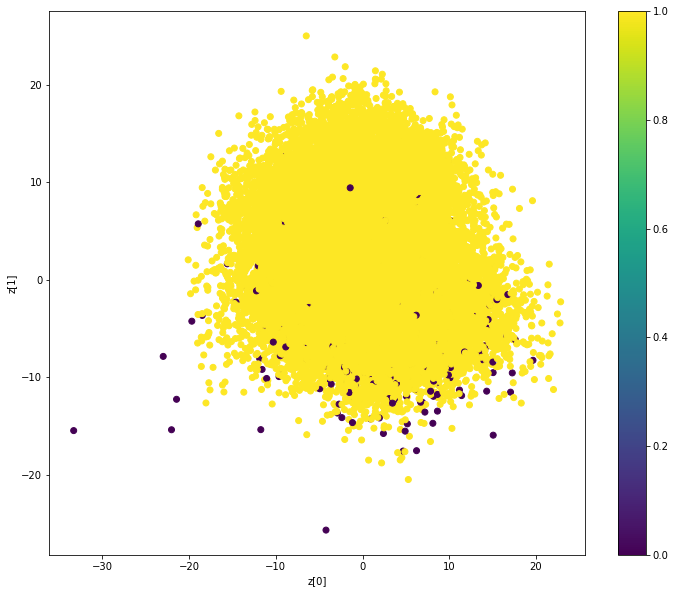

In [16]:
df_train = pd.read_csv('clean_train_5_pec_70_pec.csv')
label_y = df_train['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
generator_train = CurveSequence(df_train, batch_size=256)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
plot_label_clusters(encoder, generator_train, label_y)

# my latent_dim = 4, so the figure below is imcomplete

In [35]:
#find NOK ratio
df_train = pd.read_csv('clean_train_5_pec_70_pec.csv')
generator_train = CurveSequence(df_train, batch_size=1)

recon_error = keras.Model(encoder_inputs, [xent_loss], name="recon_error")
result = recon_error.predict_generator(generator_train, workers=4, use_multiprocessing=True, verbose=1)

52283/52283 [==============================] - 175s 3ms/step


In [36]:
judge_loss = np.percentile(result,(1-0.0064)*100)

In [37]:
print(judge_loss)

63230.75301249992


## Test on valid dataset

In [24]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels,title):
    cmap = plt.cm.binary
    cm = confusion_matrix(y_true, y_pred)
    tick_marks = np.array(range(len(labels))) + 0.5
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(4, 2), dpi=120)
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    intFlag = 0 
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        #

        if (intFlag):
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=8, va='center', ha='center')

        else:
            c = cm_normalized[y_val][x_val]
            if (c > 0.01):
                plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
            else:
                plt.text(x_val, y_val, "%d" % (0,), color='red', fontsize=7, va='center', ha='center')
    if(intFlag):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels)
    plt.yticks(xlocations, labels)
    plt.ylabel('Index of True Classes')
    plt.xlabel('Index of Predict Classes')
    plt.show()

In [38]:
#valid set test
df_valid = pd.read_csv('clean_test_5_pec_30_pec.csv')
valid_y = df_valid['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
generator_valid = CurveSequence(df_valid, batch_size=1)

recon_error = keras.Model(encoder_inputs, [xent_loss], name="recon_error")
predict = recon_error.predict_generator(generator_valid, workers=4, use_multiprocessing=True, verbose=1)

13071/13071 [==============================] - 36s 3ms/step


In [49]:
result = []
for i in range(len(predict)):
    if predict[i] < judge_loss:
        result.append(0)
    else:
        result.append(1)

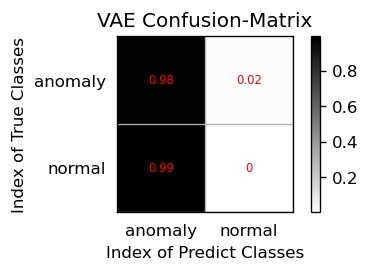

In [52]:
plot_confusion_matrix(valid_y, result, ['anomaly','normal'],'VAE Confusion-Matrix')

In [50]:
def compute_score(pred, gt):
    n_false_positives = 0
    n_true_positives = 0
    for i in range(len(pred)):
        if pred[i] == 1 and gt[i] == 0:
            n_false_positives = n_false_positives + 1
        if pred[i] == 0 and gt[i] == 0:
            n_true_positives = n_true_positives + 1
    print(n_false_positives, n_true_positives)
    return 1000*(0.42*n_true_positives - n_false_positives) / len(pred)

In [51]:
print(compute_score(result, valid_y))

2 103
3.1566062275265856


## detect on test data

In [54]:
df_test = pd.read_csv('sample_submission.csv')
df_test.head()

,FilePath,Decision
0,MPC2_IM_L2/S42_P4/2019_01_10_03h/5c36c122_3113...,OK
1,MPC2_IM_L1/S42_P3/2019_02_05_20h/5c5a888f_2022...,OK
2,MPC2_IM_L1/S42_42/2018_10_22_04h/5bcdaaa8_2041...,OK
3,MPC2_IM_L3/S42_P3/2019_02_06_01h/5c5a5dee_3255...,OK
4,MPC2_IM_L2/S42_P2/2018_09_06_21h/5b9238fe_3092...,OK


In [56]:
generator_test = CurveSequence(df_test, batch_size=1)
recon_error = keras.Model(encoder_inputs, [xent_loss], name="recon_error")
predict = recon_error.predict_generator(generator_test, workers=4, use_multiprocessing=True, verbose=1)

   250/561423 [..............................] - ETA: 1:46:51

InvalidArgumentError:  Input to reshape is a tensor with 17325 values, but the requested shape requires a multiple of 17550
	 [[node recon_error/flatten/Reshape (defined at <ipython-input-56-057fa74c01e3>:3) ]] [Op:__inference_predict_function_86366]

Function call stack:
predict_function


In [ ]:
result = []
for i in range(len(predict)):
    if predict[i] < judge_loss:
        result.append('NOK')
    else:
        result.append('OK')

In [ ]:
path_name = df_test['FilePath']
cont_list = {'FilePath':path_name, 'ResultFinalCheck':result}
    df = pd.DataFrame(cont_list, columns=['FilePath','ResultFinalCheck'])
    df.to_csv('jst.csv')